In [2]:
#Import necessary library to analyst the data 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

In [3]:
#import email 
email = pd.read_csv('../data/email.csv')

In [4]:
email.head()

,id,date,user,pc,to,cc,bcc,from,size,attachments,content
0,{R3I7-S4TX96FG-8219JWFF},01/02/2010 07:11:45,LAP0338,PC-5758,Dean.Flynn.Hines@dtaa.com;Wade_Harrison@lockhe...,Nathaniel.Hunter.Heath@dtaa.com,NaN,Lynn.Adena.Pratt@dtaa.com,25830,0,middle f2 systems 4 july techniques powerful d...
1,{R0R9-E4GL59IK-2907OSWJ},01/02/2010 07:12:16,MOH0273,PC-6699,Odonnell-Gage@bellsouth.net,NaN,NaN,MOH68@optonline.net,29942,0,the breaking called allied reservations former...
2,{G2B2-A8XY58CP-2847ZJZL},01/02/2010 07:13:00,LAP0338,PC-5758,Penelope_Colon@netzero.com,NaN,NaN,Lynn_A_Pratt@earthlink.net,28780,0,slowly this uncinus winter beneath addition ex...
3,{A3A9-F4TH89AA-8318GFGK},01/02/2010 07:13:17,LAP0338,PC-5758,Judith_Hayden@comcast.net,NaN,NaN,Lynn_A_Pratt@earthlink.net,21907,0,400 other difficult land cirrocumulus powered ...
4,{E8B7-C8FZ88UF-2946RUQQ},01/02/2010 07:13:28,MOH0273,PC-6699,Bond-Raymond@verizon.net;Alea_Ferrell@msn.com;...,NaN,Odonnell-Gage@bellsouth.net,MOH68@optonline.net,17319,0,this kmh october holliswood number advised unu...


In [5]:
email.columns

Index(['id', 'date', 'user', 'pc', 'to', 'cc', 'bcc', 'from', 'size',
       'attachments', 'content'],
      dtype='object')

In [6]:
#Convert the data format 
email['date'] = pd.to_datetime(email['date'], format='%m/%d/%Y %H:%M:%S')

In [7]:
# Frequency of emails by user
user_frequency = email['user'].value_counts()

# Number of attachments analysis (if the number of attachments is higher it should notice risk
attachment_analysis = email['attachments'].value_counts()

In [8]:
user_frequency

user
MSS0001    12034
KBP0008     9145
HTH0007     9116
HCS0003     9097
KWC0004     8997
           ...  
DAR0885      109
MTT0901       82
JRH0455       51
LPH0572       36
EAH0466       34
Name: count, Length: 1000, dtype: int64

In [9]:
email_ex = email.query("user == 'ABC0174'")
email_ex

,id,date,user,pc,to,cc,bcc,from,size,attachments,content
216,{H9M1-P4NX35JY-3657QBJL},2010-01-02 14:18:18,ABC0174,PC-5156,Melodie.C.Joyce@verizon.net,Allegra_Coffey@optonline.net,Meredith.A.Wolf@msn.com,Allegra_Coffey@optonline.net,19677,0,gold negotiating 13 vice entry coach memorial ...
217,{X3D9-I3HH81HI-6307YETM},2010-01-02 14:18:21,ABC0174,PC-5156,Gray.Josiah@verizon.net;Rachel_Hammond@optonli...,NaN,Allegra_Coffey@optonline.net;Meredith.A.Wolf@m...,Allegra_Coffey@optonline.net,23739,0,future always planets poorer jupiters only soo...
218,{E6K5-A0GP57CH-6961CEFT},2010-01-02 14:18:23,ABC0174,PC-5156,Isabella_M_Graham@juno.com,Allegra_Coffey@optonline.net,Meredith.A.Wolf@msn.com,Allegra_Coffey@optonline.net,25277,0,100 bruins eight 1997 intensive fan reprimande...
220,{L3G4-Y7XZ74SP-0237HRHY},2010-01-02 14:18:25,ABC0174,PC-5156,Rama.Vielka.Clayton@dtaa.com;Lionel.Omar.Fishe...,Melodie.Chantale.Joyce@dtaa.com;Allegra.Bree.C...,NaN,Allegra.Bree.Coffey@dtaa.com,38708,1,september 2004 out he fired useless crisis lar...
221,{J0U5-X2HR81VW-3255HJYB},2010-01-02 14:18:26,ABC0174,PC-5156,Vaughn-Blair@cox.net,Allegra_Coffey@optonline.net;Meredith.A.Wolf@m...,NaN,Allegra_Coffey@optonline.net,40514,0,nhls 01 season teammate home minnesota win str...
...,...,...,...,...,...,...,...,...,...,...,...
1928706,{T0C9-Q7PC22ID-1378HDWD},2010-12-24 15:27:48,ABC0174,PC-5156,Melodie.C.Joyce@verizon.net,Allegra_Coffey@optonline.net;Meredith.A.Wolf@m...,NaN,Allegra_Coffey@optonline.net,21369,0,across trail possibly like optical higher body...
1928708,{W5E9-S7LQ06XW-5563WHYK},2010-12-24 15:33:35,ABC0174,PC-5156,Jonah-Bird@verizon.net,Meredith.A.Wolf@msn.com,Allegra_Coffey@optonline.net,Allegra_Coffey@optonline.net,22293,0,any typhoons system visible face to into globa...
1928711,{B8T2-P8CW52KO-3156RVIX},2010-12-24 15:35:07,ABC0174,PC-5156,SDO8@netzero.com;AMR5@earthlink.net;Lacota_Lin...,Melodie.C.Joyce@verizon.net;Bianca_Roach@juno....,NaN,Allegra_Coffey@optonline.net,23567,0,200 red days am national mares university jame...
1928717,{K1V3-P1OR91JG-5589HWDS},2010-12-24 15:40:13,ABC0174,PC-5156,Linda_Matthews@verizon.net,NaN,Allegra_Coffey@optonline.net;Meredith.A.Wolf@m...,Allegra_Coffey@optonline.net,31138,0,course altocumulus sub he circumzenithal richa...


In [10]:
#@dtaa.com is company email 
def contains_dtaa(row):
    relevant_columns = ['to', 'cc', 'bcc']
    for col in relevant_columns:
        if pd.notnull(row[col]):
            # Split the column value by semicolon and check each email
            emails = row[col].split(';')
            if any('@dtaa.com' in email.strip() for email in emails):
                return True
    return False

# Create the 'not_dtaa' column
email['not_dtaa'] = ~email.apply(contains_dtaa, axis=1)

In [11]:
#Check values fo email
email['not_dtaa'].value_counts()

not_dtaa
False    1602556
True     1027423
Name: count, dtype: int64

In [12]:
#remove @dtaa.com because 
email_filtered = email[email['not_dtaa'] == True].reset_index(drop=True)

In [13]:
email_filtered.query("user == 'RAR0725'")

,id,date,user,pc,to,cc,bcc,from,size,attachments,content,not_dtaa
3892,{Y8S7-G7WH10AS-8811REPV},2010-01-05 10:39:38,RAR0725,PC-4159,XLB73@comcast.net,NaN,NaN,Ray-Raphael@netzero.com,44162,0,themselves items deserts continuing 72 6 moose...,True
14015,{R9I0-W4HG18AO-2161FRUF},2010-01-08 14:43:25,RAR0725,PC-4159,Jescie_Jenkins@aol.com,NaN,NaN,Ray-Raphael@netzero.com,25832,0,concentrate embezzlement encounter class famil...,True
23302,{G6U2-D1FG26XM-6715LPMF},2010-01-13 16:41:03,RAR0725,PC-4159,Jescie_Jenkins@aol.com,NaN,NaN,Ray-Raphael@netzero.com,34669,0,outskirts grudging without significant real il...,True
32891,{Z6E2-K3YS91VO-0601LCHI},2010-01-19 08:34:45,RAR0725,PC-4159,Isadora_B_Brewer@cox.net;Contreras-Mufutau@cha...,NaN,NaN,Ray-Raphael@netzero.com,48359,0,slender meeting run linked linked few size win...,True
37912,{K5W4-A1FL69ZV-4861MLKD},2010-01-20 15:55:59,RAR0725,PC-4159,Cherokee.T.Ramirez@juno.com;Galena.D.Francis@h...,NaN,NaN,Ray-Raphael@netzero.com,16874,0,gradually dreamed wall free speak nearer embro...,True
...,...,...,...,...,...,...,...,...,...,...,...,...
461270,{D5R0-T4CY32ST-8872VFTJ},2010-08-06 08:02:12,RAR0725,PC-4159,Galena.D.Francis@hotmail.com,NaN,NaN,Ray-Raphael@netzero.com,31740,0,buried america free front model 15 talent hang...,True
470294,{X1I6-B0FD11CC-2196GAMJ},2010-08-11 07:52:56,RAR0725,PC-4159,Ann.J.Potts@bellsouth.net,NaN,NaN,Ray-Raphael@netzero.com,26777,0,caves than inter groups agency andres only die...,True
476072,{L6N0-S5BI45TW-2149OQXJ},2010-08-13 08:36:58,RAR0725,PC-4159,FRB11@earthlink.net,NaN,NaN,Ray-Raphael@netzero.com,14992,0,has rain probably condenses sign speculated de...,True
489399,{G7J5-K7PK38GL-2646XOSV},2010-08-19 13:29:01,RAR0725,PC-4159,Yvette_J_Vang@comcast.net,NaN,NaN,Ray-Raphael@netzero.com,22437,1,daily spooner applied alberta iowa ft person c...,True


In [14]:
user_frequency = email_filtered['user'].value_counts()

In [15]:
user_frequency

user
MSS0001    5898
HCS0003    4917
KWC0004    4370
KBP0008    4364
BTW0005    4008
           ... 
EHB0824      44
MTT0901      25
JRH0455      22
LPH0572      17
EAH0466      16
Name: count, Length: 1000, dtype: int64

In [16]:
#check the remaining TP users(1)
email_filtered['user'].to_csv('../data/user_frequency.csv', index=False)
#70 remaining TP cases


In [17]:
user_frequency.mean()

1027.423

In [18]:
sizing = email_filtered['size'].value_counts()

In [19]:
sizing

size
23439    70
24225    70
28614    69
26713    69
26903    69
         ..
67795     1
79517     1
64899     1
53933     1
77930     1
Name: count, Length: 57304, dtype: int64

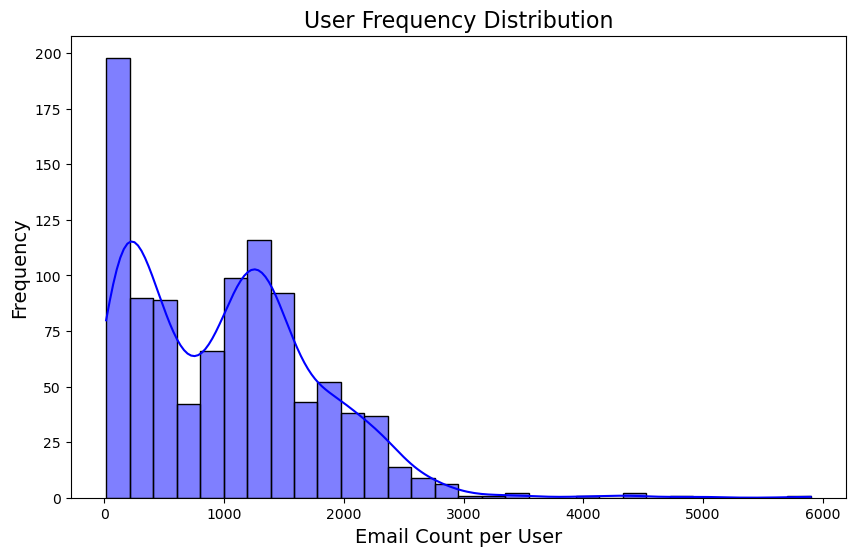

In [20]:
plt.figure(figsize=(10, 6))
sns.histplot(user_frequency, kde=True, bins=30, color='blue')
plt.title('User Frequency Distribution', fontsize=16)
plt.xlabel('Email Count per User', fontsize=14)
plt.ylabel('Frequency', fontsize=14);

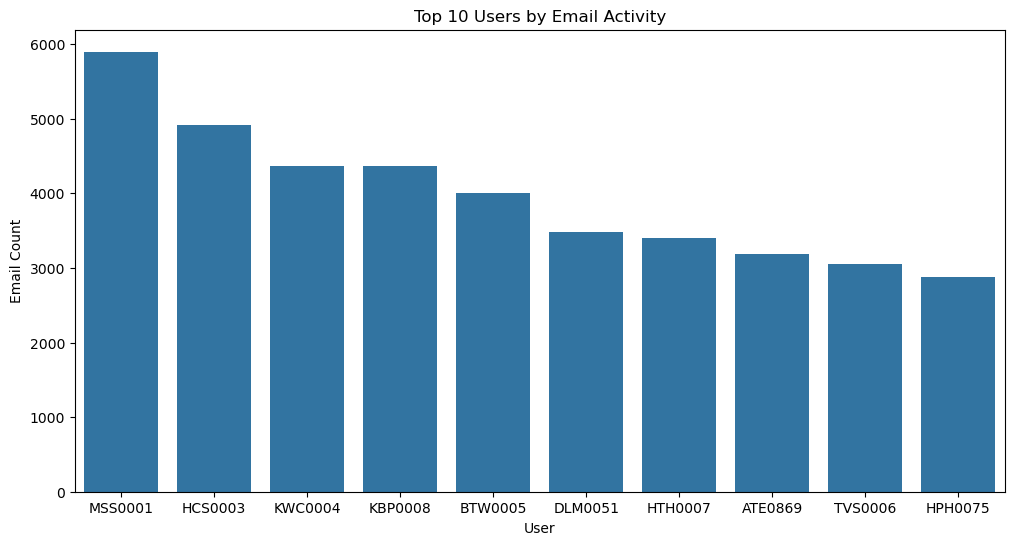

In [21]:
#find the top users to 
top_users = email_filtered['user'].value_counts().head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_users.index, y=top_users.values)
plt.title('Top 10 Users by Email Activity')
plt.xlabel('User')
plt.ylabel('Email Count')
plt.show()

In [22]:
# impute Missing values in 'cc' and 'bcc'
email_filtered['cc'] = email_filtered['cc'].fillna('')
email_filtered['bcc'] = email_filtered['bcc'].fillna('')

#summary number of recipient from to cc, bcc
email_filtered['num_recipients'] = email_filtered['to'].str.count(';') + email_filtered['cc'].str.count(';') + email_filtered['bcc'].str.count(';') + 1
email_filtered['hour'] = email_filtered['date'].dt.hour
email_filtered['day_of_week'] = email_filtered['date'].dt.dayofweek 

# Define working hours and working days
working_hours_start = 9 # 9 AM
working_hours_end = 17  # 5 PM
working_days = [0, 1, 2, 3, 4]  # Monday=0, Sunday=6

#is working_time columns 
email_filtered['is_working_time'] = (
    (email_filtered['hour'] >= working_hours_start) & 
    (email_filtered['hour'] < working_hours_end) & 
    email_filtered['day_of_week'].isin(working_days))

# Drop rows sent during working hours and working days
email_filtered = email_filtered[~email_filtered['is_working_time']]

# Drop the column if no longer needed
email_filtered.drop(columns=['is_working_time'], inplace=True)

In [23]:
#check the remaining TP users(2)
email_filtered['user'].to_csv('../data/filtered_users.csv', index=False)

#70 remaining TP cases , the action were identified as high risk to be threats that occurred outside working hours and day (9 AM - 5 PM)
#check information agianst with insider info using Verify.ipynb

In [24]:
# Calculate the mean frequency
mean_frequency = user_frequency.mean()

# Filter users who send more emails than the mean
users_above_mean = user_frequency[user_frequency > mean_frequency]

In [25]:
# Predefined list of public domains
public_domains = ['gmail.com', 'yahoo.com', 'outlook.com', 'hotmail.com', 'msn.com', 'icloud.com', 'aol.com', 'live.com', 'protonmail.com', 'zoho.com', 'mail.com', 'gmx.com']

def contains_public_domain(row):
    relevant_columns = ['to', 'cc', 'bcc']
    for col in relevant_columns:
        if pd.notnull(row[col]):
            emails = row[col].split(';')
            for email in emails:
                domain = email.strip().split('@')[-1]
                if domain in public_domains:
                    return True
    return False

# create the 'is_public_domain' column
filtered_email = email_filtered.assign(is_public_domain=email_filtered.apply(contains_public_domain, axis=1))


In [26]:
filtered_email['is_public_domain'].value_counts()

is_public_domain
True     129873
False    109953
Name: count, dtype: int64

In [27]:
# Separate the DataFrame into two based on the 'is_public_domain' column
public_domain_df = filtered_email[filtered_email['is_public_domain'] == True]
non_public_domain_df = filtered_email[filtered_email['is_public_domain'] == False]

In [28]:

# Extract domains from email addresses
def extract_domains(emails):
    if pd.notnull(emails):  
            return [email.strip().split('@')[-1] for email in emails.split(';') if '@' in email]
    return []

# 'non_public_domain_df' DataFrame will get the list of domain to identify vendor_domains

non_public_domain_df.loc[:, 'to_domains'] = non_public_domain_df.loc[:,'to'].apply(extract_domains)
non_public_domain_df.loc[:, 'cc_domains'] = non_public_domain_df.loc[:,'cc'].apply(extract_domains)
non_public_domain_df.loc[:, 'bcc_domains'] = non_public_domain_df.loc[:,'bcc'].apply(extract_domains)


In [29]:
# List of domains with vendors from non_public_domain_df
vendor_domains = ['boeing.com', 'raytheon.com', 'hp.com', 'harris.com', 'northropgrumman.com', 'lockheedmartin.com']

def is_vendor_email(email):
    if pd.notnull(email):
        domain = email.split('@')[-1]
        return domain in vendor_domains
    return False
filtered_email['is_vendor'] = False

for index, row in filtered_email.iterrows():
    for col in ['to', 'cc', 'bcc']:
        emails = row[col].split(';') if pd.notnull(row[col]) else []
        if any(is_vendor_email(email) for email in emails):
            filtered_email.at[index, 'is_vendor'] = True
            break  

filtered_email_no_vendors = filtered_email[filtered_email['is_vendor'] == False].copy()


In [30]:
#Data is clean
filtered_email_no_vendors

,id,date,user,pc,to,cc,bcc,from,size,attachments,content,not_dtaa,num_recipients,hour,day_of_week,is_public_domain,is_vendor
0,{R0R9-E4GL59IK-2907OSWJ},2010-01-02 07:12:16,MOH0273,PC-6699,Odonnell-Gage@bellsouth.net,,,MOH68@optonline.net,29942,0,the breaking called allied reservations former...,True,1,7,5,False,False
1,{G2B2-A8XY58CP-2847ZJZL},2010-01-02 07:13:00,LAP0338,PC-5758,Penelope_Colon@netzero.com,,,Lynn_A_Pratt@earthlink.net,28780,0,slowly this uncinus winter beneath addition ex...,True,1,7,5,False,False
2,{A3A9-F4TH89AA-8318GFGK},2010-01-02 07:13:17,LAP0338,PC-5758,Judith_Hayden@comcast.net,,,Lynn_A_Pratt@earthlink.net,21907,0,400 other difficult land cirrocumulus powered ...,True,1,7,5,False,False
3,{E8B7-C8FZ88UF-2946RUQQ},2010-01-02 07:13:28,MOH0273,PC-6699,Bond-Raymond@verizon.net;Alea_Ferrell@msn.com;...,,Odonnell-Gage@bellsouth.net,MOH68@optonline.net,17319,0,this kmh october holliswood number advised unu...,True,3,7,5,True,False
4,{X8T7-A6BT54FP-7241DLBV},2010-01-02 07:36:03,HVB0037,PC-7979,Gaines-Joseph@msn.com,Hollee_Becker@hotmail.com,,Hollee_Becker@hotmail.com,44345,0,little equal k is group cannot though with lea...,True,1,7,5,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1027418,{J3O2-A6NI94GM-6642MNGD},2011-05-16 20:48:14,BCM0653,PC-5717,Jonah.M.Wilder@aol.com,,,BCM6@cox.net,34383,0,in pursue these morn inspiration sheet minded ...,True,1,20,0,True,False
1027419,{G8N7-J7WL51EB-8350IVZY},2011-05-16 20:49:51,OSH0655,PC-3998,Anjolie.Bowman@gmail.com,,,Harrison_Olympia@earthlink.net,19806,0,monastery anything english metaphors general j...,True,1,20,0,True,False
1027420,{U3I3-Q2JG94JZ-7640PECH},2011-05-16 20:52:54,DID0650,PC-0444,Talley_Eagan@msn.com;Jonah.M.Wilder@aol.com;Ur...,BCM6@cox.net,,Denise.I.Doyle@optonline.net,39889,0,sudden maritime storm pinpointing across gradu...,True,3,20,0,True,False
1027421,{L6B7-F7RU89CD-0355JGGE},2011-05-16 21:08:12,LAF0991,PC-4973,Doyle.Grant@netzero.com;HAV856@charter.net,,,Ferrell.Lucas@sbcglobal.net,41336,1,lifted documents 65 declined revival 14 unprec...,True,2,21,0,False,False


In [31]:
filtered_email_no_vendors['user'].value_counts()

user
ATE0869    1520
DLM0051    1449
JDC0030    1318
MSS0001    1214
KBP0008    1067
           ... 
FMG0527       3
HMM0108       3
CYA0506       3
BVN0514       2
AAF0535       1
Name: count, Length: 1000, dtype: int64

In [32]:
public_domain_df['user'].value_counts()

user
DLM0051    1449
ATE0869     963
RZC0746     917
HCS0003     864
MSS0001     843
           ... 
BVN0514       1
AAF0535       1
CYA0506       1
AAS0442       1
MTT0901       1
Name: count, Length: 999, dtype: int64

In [33]:
public_domain_df.columns

Index(['id', 'date', 'user', 'pc', 'to', 'cc', 'bcc', 'from', 'size',
       'attachments', 'content', 'not_dtaa', 'num_recipients', 'hour',
       'day_of_week', 'is_public_domain'],
      dtype='object')

In [34]:
contect_df = public_domain_df[['user', 'content','num_recipients','hour','day_of_week','attachments','size']]

In [35]:
contect_df.to_csv('../data/public_domain_df.csv')  #public_domain_df verify 70 TPs cases

In [36]:
non_public_domain_df.to_csv('../data/non_public_domain_counts.csv')  #non_public_domain_df verify 6 TPs cases

In [37]:
contect_df.nunique()

user                 999
content           129873
num_recipients         6
hour                  18
day_of_week            7
attachments           10
size               38156
dtype: int64

In [38]:
insider_df = pd.read_csv('../data/filtered_inside.csv') #import insider to generate dataset for analyst

insider_df = insider_df.drop(columns=['Unnamed: 0', 'dataset', 'scenario', 'details', 'start', 'end'])


In [39]:
# Extract the list of insider users
insider_users = insider_df['user'].unique()

# Filter the content DataFrame for insider users
insider_data = contect_df[contect_df['user'].isin(insider_users)]

insider_data.loc[:, 'threat_flag'] = True



# Identify non-insider users
non_insider_users = contect_df[~contect_df['user'].isin(insider_users)]['user'].unique()

# Randomly select 250 users from non-insider users
random_users = pd.Series(non_insider_users).sample(n=70, random_state=42)


# Filter the content DataFrame for these 250 random users
random_data = contect_df[contect_df['user'].isin(random_users)]

random_data.loc[:, 'threat_flag'] = False

# Combine insider data with the random data (320 users do the feature)
combined_data = pd.concat([insider_data, random_data], ignore_index=True)

In [40]:
combined_data.nunique() 

user                140
content           15504
num_recipients        6
hour                 18
day_of_week           7
attachments          10
size              12388
threat_flag           2
dtype: int64

In [41]:
combined_data.to_pickle('../data/combined_data.pkl')

In [42]:
combined_data

,user,content,num_recipients,hour,day_of_week,attachments,size,threat_flag
0,ABC0174,gold negotiating 13 vice entry coach memorial ...,1,14,5,0,19677,True
1,ABC0174,future always planets poorer jupiters only soo...,3,14,5,0,23739,True
2,ABC0174,100 bruins eight 1997 intensive fan reprimande...,1,14,5,0,25277,True
3,ABC0174,nhls 01 season teammate home minnesota win str...,2,14,5,0,40514,True
4,ABC0174,naturally formed nuclei rising hours york expe...,4,14,5,0,20614,True
...,...,...,...,...,...,...,...,...
15499,RVC0232,substantial last not not 120 received recover ...,2,17,0,0,76284,False
15500,KAT0489,20 horizontally morning left inversion radiate...,4,17,0,2,21608,False
15501,RGN0408,led regarded personal low man smashing lot par...,2,17,0,1,27696,False
15502,MAE0331,have ukraine be pron money terminally more fre...,2,17,0,0,32210,False


In [43]:
combined_data['threat_flag'].value_counts()

threat_flag
False    10294
True      5210
Name: count, dtype: int64